# Szűrés folytonos wavelet transzformációval

A folytonos wavelet transzformáció kiválóan alkalmazható a jel elemzésén túlmenően a jelek **szűrésére** is.

Az előzőekben az évszakonként átlagolt, éves ciklus nélküli tengerfelszín hőméréséklet [adatokat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) elemeztük. Használjuk ismét a munkakörnyezetbe feltöltött [sst_nino3.dat](http://paos.colorado.edu/research/wavelets/wave_python/sst_nino3.dat) állományt és végezzük el az adatok szűrését.

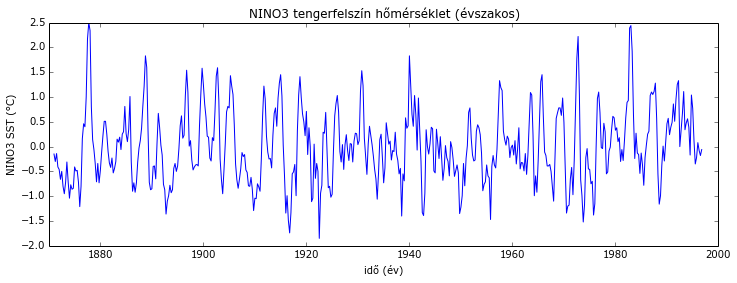

In [2]:
from __future__ import unicode_literals
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pyplot as plt

sst = np.loadtxt('sst_nino3.dat')
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # időpontok tömbje
xlim = ([1870, 2000])


%matplotlib inline
plt.figure(figsize=(12, 4))
plt.plot(time, sst)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('NINO3 SST (°C)')
plt.title('NINO3 tengerfelszín hőmérséklet (évszakos)')
plt.hold(False)

Szűrjük a jelet úgy, hogy a 2-8 éves periódusú rész maradjon csak meg benne.

Korábban már megírtuk az inverz wavelet transzformáció függvényét, használjuk ezt ismét.

In [3]:
def icwt(W, sj, dt, dj=1/8, mother='morlet'):
    """
    Folytonos inverz wavelet transzformáció.

    Paraméterek
    ----------
    W : a wavelet transzformált
    sj : skála indexek vektora
    dt : mintavételezés intervalluma
    dj : diszkrét skála intervallum, alapértelmezésben 0.125.
    mother : anya wavelet (alapértelmezés: Morlet)
    
    Eredmény
    --------
    iW : inverz wavelet transzformált
    """
    mother = mother.upper()
    if mother == 'MORLET':
        Cd = 0.7785  
        psi0 = 0.751126
    elif mother == 'PAUL': # Paul, m=4
        Cd = 1.132
        psi0 = 1.07894
    elif mother == 'DOG':   # Dog, m=2
        Cd = 3.541
        psi0 = 0.86733
    else:
        raise Error('Mother must be one of Morlet, Paul, DOG')

    a, b = W.shape
    c = sj.size
    if a == c:
        sj = (np.ones([b, 1]) * sj).transpose()
    elif b == c:
        sj = np.ones([a, 1]) * sj
    else:
        raise Warning('Input array dimensions do not match.')

    iW = dj * np.sqrt(dt) / (Cd * psi0) * (
        np.real(W) / np.sqrt(sj)).sum(axis=0)
    return iW

pad = 1  # zérus kitöltés (javasolt)
dj = 0.125  # 8 rész-oktáv (egy oktávon belül)
s0 = 2 * dt  # 6 hónapos kezdő skála
j1 = 7 / dj  # 7 oktáv
mother = 'MORLET'

Végezzük el a CWT-t, számítsuk ki a korrigált jel teljesítményt, szűrjük a 2-8 éves periódusra és rekonstruáljuk inverz CWT-vel a szűrt jelet.

In [4]:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
scale_ext = np.outer(scale,np.ones(n))
power = (np.abs(wave))**2 /scale_ext  # energiaspektrum (korrigált)

# szűrés 2-8 éves periódusra
zmask = np.logical_or(scale_ext<2, scale_ext>=8) # itt kell kinullázni
power[zmask] = 0.0
wavethr = np.copy(wave)
wavethr[zmask] = 0.0

# rekonstrukció inverz wavelet transzformációval
x = icwt(wavethr, scale, dt, dj, 'morlet')

Rajzoljuk fel a wavelet térképet és a szűrt jelet:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


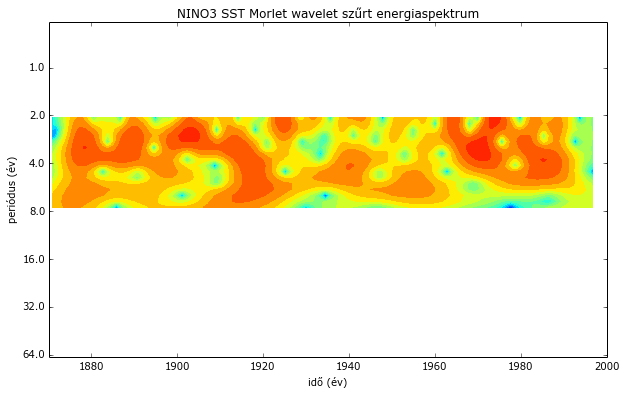

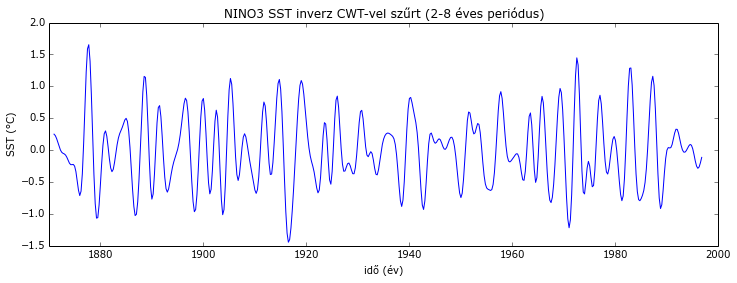

In [5]:
import matplotlib

plt.figure(figsize=(10, 6))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(time, period, np.log2(power), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (év)')
plt.ylabel('periódus (év)')
plt.title('NINO3 SST Morlet wavelet szűrt energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time, x)
plt.xlim(xlim[:])
plt.xlabel('idő (év)')
plt.ylabel('SST (°C)')
plt.title('NINO3 SST inverz CWT-vel szűrt (2-8 éves periódus)')
plt.show()

## Kerék gyorsulás adatok szűrése CWT-vel

A szűréshez [Vinkó Ákos](http://www.epito.bme.hu/vinko-akos) bicikli kerékre szerelt 3 tengelyű gyorsulásmérő adatait használjuk fel, amelyeket *spline interpolációval* egyenlő, 0.01 s-os időközökre [interpoláltunk](aint.dat).

Először is beolvassuk az $a_x$, $a_y$ érintő irányú és centrifugális gyorsulás adatokat és felrajzoljuk.

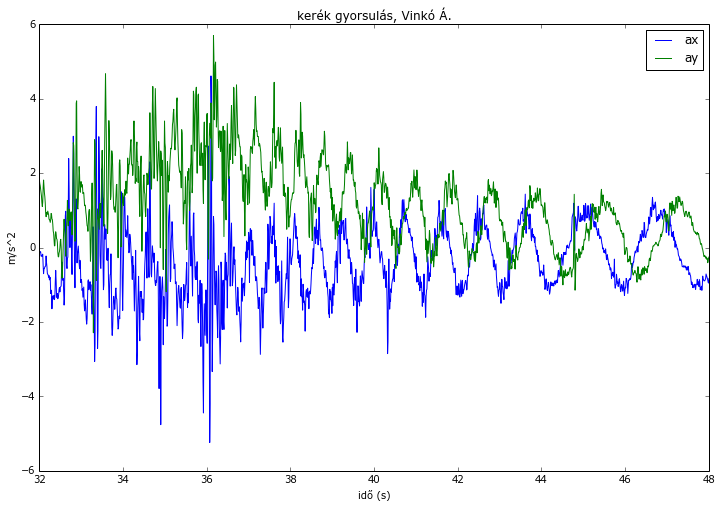

In [6]:
aint = np.loadtxt('aint.dat')
tint= aint[:,0]
axi = aint[:,1]
ayi = aint[:,2]
n = len(tint)
dt = 0.01

xlim = [32,48]
plt.figure(figsize=(12, 8))
plt.hold(True)
plt.plot(tint, axi, label='ax')
plt.plot(tint, ayi, label='ay')
plt.xlim(xlim[:])
plt.xlabel('idő (s)')
plt.ylabel('m/s^2')
plt.title('kerék gyorsulás, Vinkó Á.')
plt.legend()
plt.show()

Kiszámítjuk az $a_x$ gyorsulás adatsor folytonos wavelet transzformáltját (Morlet wavelettel):

In [7]:
pad = 1  
dj = 0.125 
s0 = 2*dt
j1 = 10/dj 
mother = 'MORLET'

wave, period, scale, coi = wavelet(axi,dt,pad,dj,s0,j1,mother)
# energiaspektrum (Compo)
power = (np.abs(wave)) ** 2 
# szűrés - küszöbértékekkel
pvar = np.std(power)**2  # jel variancia
lvl = 0.15     # küszöbszint (jel varianciához viszonyítva)
thr = lvl*pvar
zmask = power <=thr # itt kell kinullázni
powerthr = np.copy(power)
powerthr[zmask] = 0.0
wavethr = np.copy(wave)
wavethr[zmask] = 0.0

# rekonstrukció inverz wavelet transzformációval
axr = icwt(wavethr, scale, dt, dj, 'morlet')

Rajzoljuk fel az érintő irányú gyorsulás wavelet térképét:

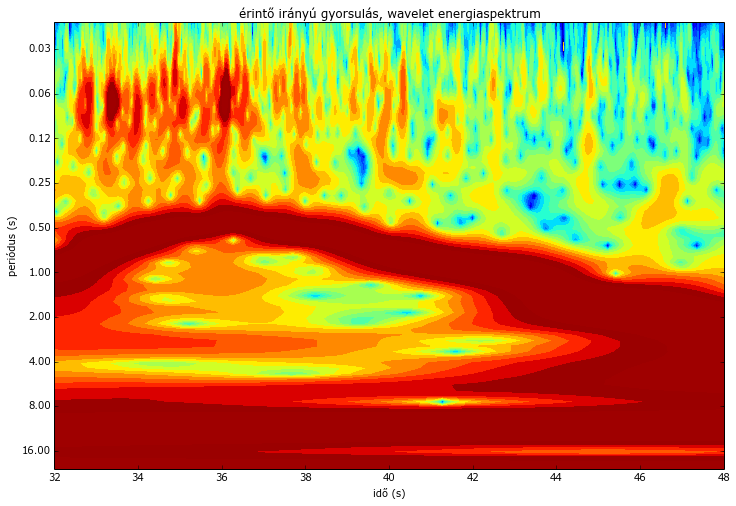

In [8]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(tint, period, np.log2(power), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (s)')
plt.ylabel('periódus (s)')
plt.title('érintő irányú gyorsulás, wavelet energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

Rajzoljuk fel a szűrt wavelet térképet és a szűrt jelet:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


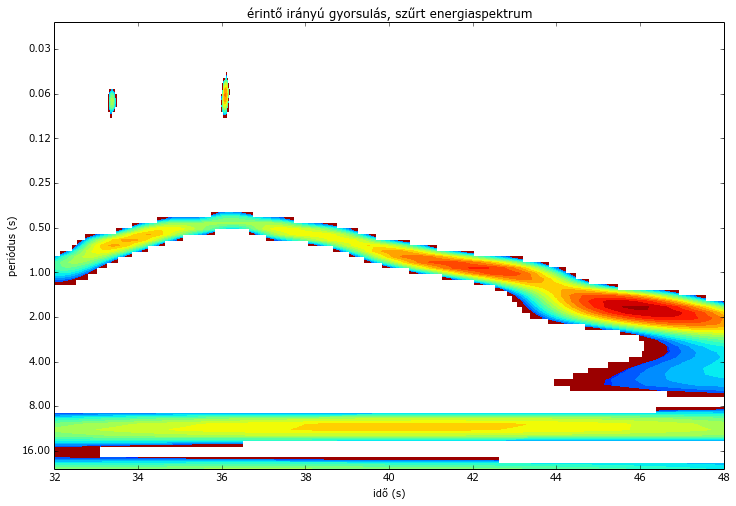

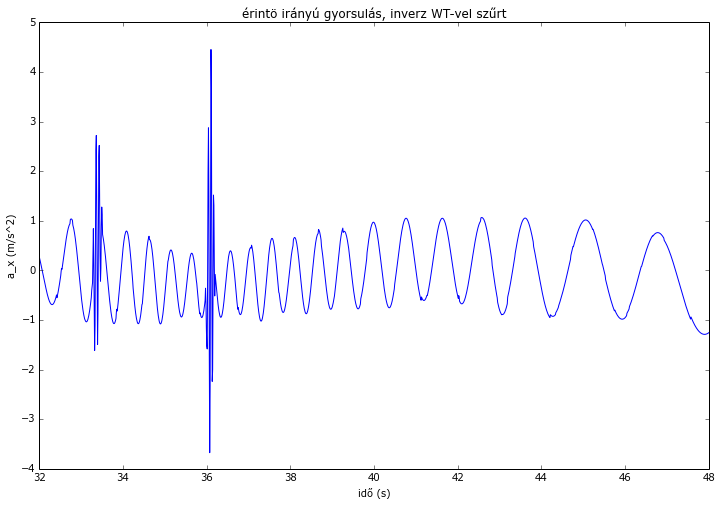

In [9]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(tint, period, np.log2(powerthr), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (s)')
plt.ylabel('periódus (s)')
plt.title('érintő irányú gyorsulás, szűrt energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(tint, axr)
plt.xlim(xlim[:])
plt.xlabel('idő (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('érintö irányú gyorsulás, inverz WT-vel szűrt')
plt.show()

A 33 s-nál, illetve 36 s-nál fellépő periódikus tranziensek valószínűleg a kipörgő hajtott bicikli kerék miatt fellépő gyorsulások. A közelebbi vizsgálatuk is erre utal:

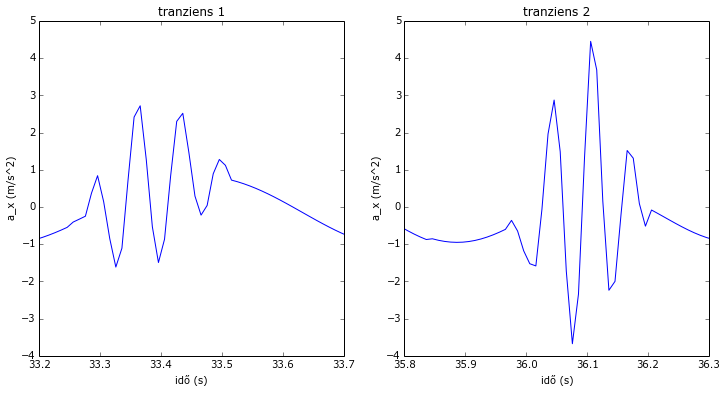

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(tint, axr)
plt.xlim([33.2,33.7])
plt.xlabel('idő (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('tranziens 1')
plt.subplot(122)
plt.plot(tint, axr)
plt.xlim([35.8,36.3])
plt.xlabel('idő (s)')
plt.ylabel('a_x (m/s^2)')
plt.title('tranziens 2')
plt.show()

### Szignifikancia vizsgálat

Felmerülhet bennünk a kérdés, hogy vajon szignifikánsak-e a jelben ezek a tranziensek?

Ahogy korábban tanultuk, ehhez el kell végeznük a wavelet térképhez kapcsolódó szignifikancia vizsgálatot. A megfelelő háttér spektrum felvétele érdekében az $a_x$ gyorsulás idősor adatok 1-es és 2-es késleltetéshez tartozó autokorrelációit kell megbecsülnünk és ezekből átlagot számítanunk az $\alpha=(\alpha_1 + \sqrt{\alpha_2})/2$ képlet segítségével.

In [17]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

acfx = autocorr(axi)

# átlagos lag-1 autokorreláció
lag1,lag2 = acfx[1]/acfx[0], acfx[2]/acfx[0]
lag1m = (lag1 + np.sqrt(lag2))/2
print "átlagos lag-1 autokorreláció: %.3f" % lag1m

átlagos lag-1 autokorreláció: 0.923


Most már előállíthatjuk a szignifikancia vizsgálathoz szükséges adatokat.

In [18]:
# szignifikancia szintek
signif = wave_signif(([1.0]), dt=dt, sigtest=0, scale=scale, lag1=0.923, mother='MORLET')
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # ahol > 1-nél, ott az energia szignifikáns

Rajzoljuk fel ismét az $a_x$ gyorsulás adatok wavelet térképét, kiegészítve a szignifikancia szinthez rendelt szintvonalakkal.

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


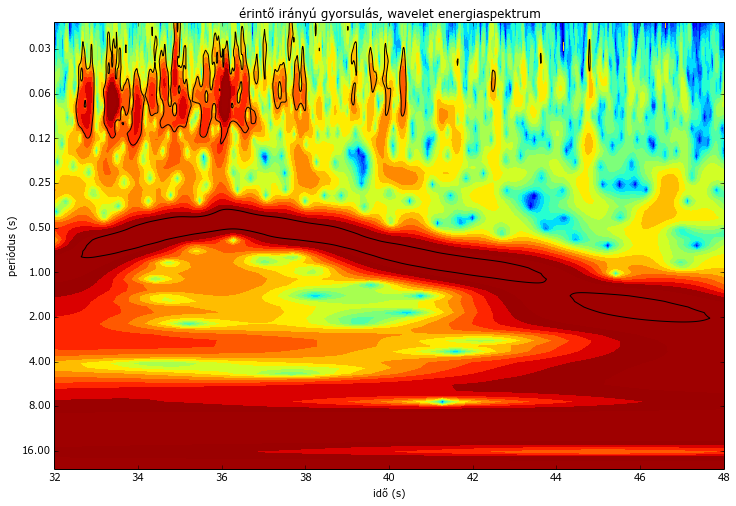

In [20]:
plt.figure(figsize=(12, 8))
levels = np.array([2**i for i in range(-15,5)])
CS = plt.contourf(tint, period, np.log2(power), len(levels))  
im = plt.contourf(CS, levels=np.log2(levels))
plt.xlabel('idő (s)')
plt.ylabel('periódus (s)')
plt.title('érintő irányú gyorsulás, wavelet energiaspektrum')
plt.xlim(xlim[:])
plt.yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
# 95%-os szignifikancia szint
plt.hold(True)
plt.contour(tint, period, sig95, [-99, 1], colors='k')
plt.show()